# Cosmics!

It's time to extract some cosmics from some darks to make training data. Let's do this.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize # For displaying the preproc images

import os
import re
import glob
import json
from pathlib import Path

import joincosmics

In [4]:
# Took this from DESIspec.
def parse_sec_keyword(value):
    m = re.search(r'\[(\d+):(\d+)\,(\d+):(\d+)\]', value)
    if m is None:
        m = re.search(r'\[(\d+):(\d+)\, (\d+):(\d+)\]', value)
        if m is None :
            raise ValueError('unable to parse {} as [a:b, c:d]'.format(value))

    xmin, xmax, ymin, ymax = tuple(map(int, m.groups()))

    return np.s_[ymin - 1:ymax, xmin - 1:xmax]

# Subtracts off the bias overscan region to normalize the four quadrants.
def subtract_bias(img, camera):
    # Camera defines which camera to use, e.x. "R5"
    quads = ["A", "B", "C", "D"]
    corners = {}

    for q in quads:
        # Gets the data from the overscan region and subtracts the median from the data region.
        # More accurate would be to median each row or column etc but this is quick and dirty.
        o_i = parse_sec_keyword(hdus[camera].header["ORSEC" + q])
        d_i = parse_sec_keyword(hdus[camera].header["DATASEC" + q])
        overscan = img[o_i].copy()
        corners[q] = img[d_i] - np.median(overscan)
        
    # Smash the corners back together to make the large image.
    lower = np.concatenate((corners["A"], corners["B"]), axis=1)
    higher = np.concatenate((corners["C"], corners["D"]), axis=1)
    return np.concatenate((lower, higher), axis=0)

def pretty_disp(img):
    # Normalization to display the image nicer.
    zscale = ZScaleInterval()
    norm = ImageNormalize(img, zscale)

    fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
    ax.imshow(img, cmap='gray', origin="lower", interpolation="none", norm=norm)

In [5]:
ROOT = Path('/project/projectdirs/desi/spectro/data/')
ROOT_PRE = Path('/project/projectdirs/desi/spectro/redux/daily/preproc/')
assert ROOT.exists()

First we plot a zero to ensure that everything is working well. These are the kind of images we will be extracing the cosmics themselves from. I will be taking them out of the dark and overlaying them over the medians.

Filename: /project/projectdirs/desi/spectro/data/20191108/00025657/desi-00025657.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SPS           1 CompImageHDU     55   (10,)   int16   
  2  Z2            1 CompImageHDU    137   (4256, 4194)   int16   
  3  R2            1 CompImageHDU    137   (4256, 4194)   int16   
  4  B2            1 CompImageHDU    137   (4232, 4162)   int16   
  5  Z7            1 CompImageHDU    137   (4256, 4194)   int16   
  6  R7            1 CompImageHDU    137   (4256, 4194)   int16   
  7  B7            1 CompImageHDU    137   (4232, 4162)   int16   
  8  Z6            1 CompImageHDU    137   (4256, 4194)   int16   
  9  R6            1 CompImageHDU    137   (4256, 4194)   int16   
 10  B6            1 CompImageHDU    137   (4232, 4162)   int16   
 11  Z0            1 CompImageHDU    137   (4256, 4194)   int16   
 12  R0            1 CompImageHDU    137   (4256, 4194)   int16   
 

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


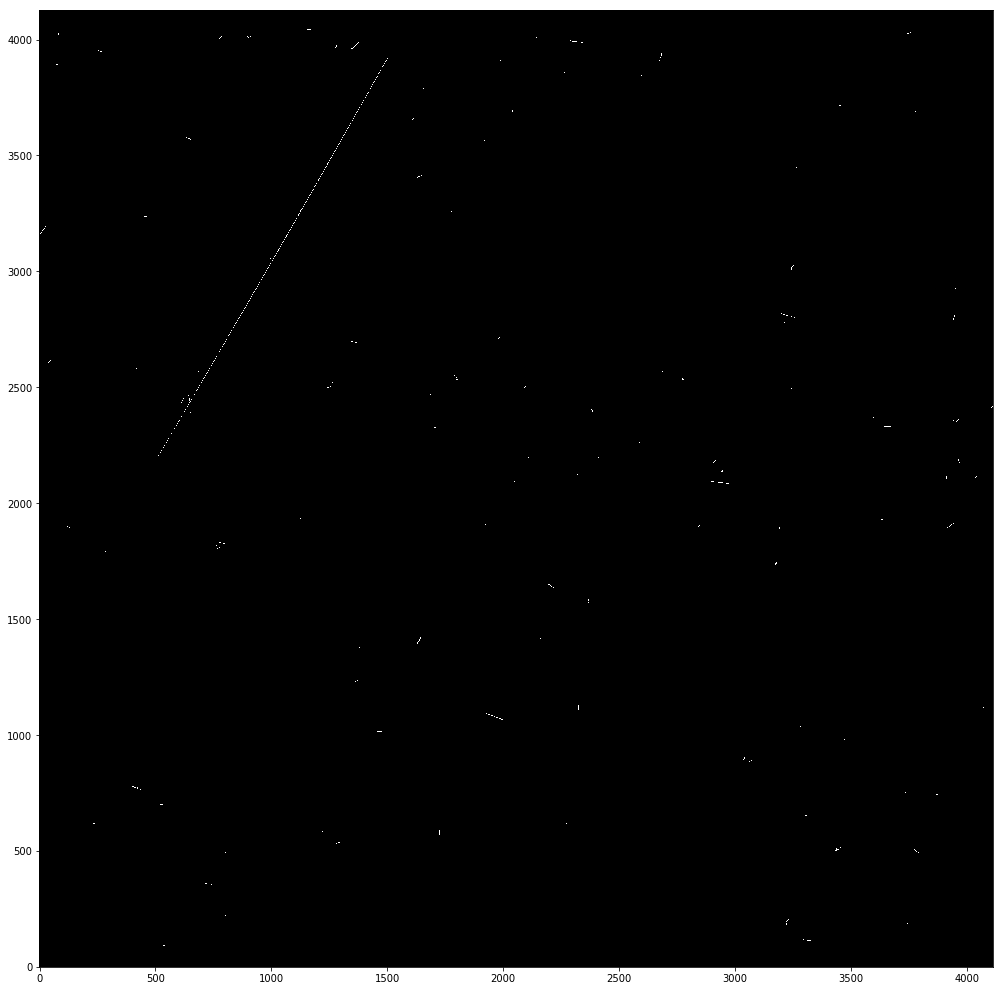

In [6]:
hdus = fits.open(os.path.join(ROOT, "20191108", "00025657", "desi-00025657.fits.fz"))
print(hdus.info())
img = hdus["R1"].data

# Subtract the bias to normalize everything.
img2 = subtract_bias(img, "R1") > 10

fig, ax = plt.subplots(1,1, figsize=(14,14), tight_layout=True)
ax.imshow(img2, cmap='gray', origin="lower", interpolation="none")

Load all the cosmics that we already extracted. See cosmic_extractor.ipynb for details on how this works.

In [30]:
cam = "R3"
cosmics = np.load("cosmic_data/cosmics.npy")
cosmic_masks = np.load("cosmic_data/cosmic_masks.npy")
cosmic_ivar = np.load("cosmic_data/cosmics_ivar.npy")
exp_time = np.load("cosmic_data/exp.npy")
nums = np.load("cosmic_data/nums.npy")

print(len(cosmics))

43103


Plots the # of cosmics versus exposure time and finds the fit. The reason we do this is because when we generate the training data, we want to "simulate" an exposure time, which will naturally change the number of cosmics that end up in the resultant image. This fit is used to calculate the number of cosmics that we will overlay over the median.

In [12]:
print(len(nums))
print(len(exp_time))
exp_time = np.asarray(exp_time)
print(np.min(exp_time))
nums = np.asarray(nums)

fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Exposure Time (s)")
plt.ylabel("Number of Cosmic Rays")
plt.scatter(exp_time, nums, s=2)

# Linear fits. m,b is non zero y intercept. a is forced 0 y intercept.
m,b = np.polyfit(exp_time, nums, 1)
x = np.asarray(exp_time).reshape(-1, 1)
a, _, _, _ = np.linalg.lstsq(x, nums)

# Plot the found fit above
x = np.arange(0, 1200, 1)
lbl = "y=" + str(a) + "*x + " + str(0)
plt.plot(x, a*x + 0, c='r', label= lbl)

# Finds the fit again but this time ignoring the 1200s exposures.
# We do this because at 1200s we expect the cosmics to start intersecting, so the # of cosmics
# will "taper off" at the high exposure times. 
exp_time2 = exp_time[exp_time < 1200]
nums2 = nums[exp_time < 1200]
m,b = np.polyfit(exp_time2, nums2, 1)
x = np.asarray(exp_time2).reshape(-1, 1)
a, _, _, _ = np.linalg.lstsq(x, nums2)

x = np.arange(0, 1200, 1)
lbl = "y=" + str(a) + "*x + " + str(0) + " (ignoring 1200s exp)"
plt.plot(x, a*x + 0, c='g', label= lbl)

plt.title(f"{cam} Number of Cosmic Rays vs Exposure Time (darks)")
plt.legend()
plt.savefig(f"{cam}-cosmics.png", dpi=256)

46
46
60.0


We wanna display a cosmic and the ivar for the cosmic to make sure we trimmed out the same thing in both.

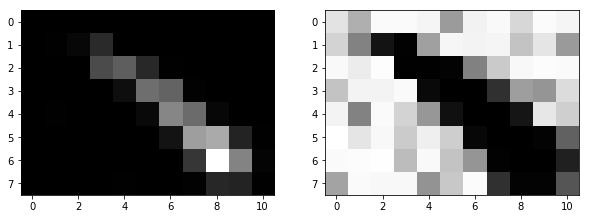

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cosmics[580], cmap="gray")
ax[1].imshow(cosmic_ivar[580], cmap="gray")

Displaying a clean median.

In [14]:
# Displaying final result for testing.
med_hdus = fits.open("medians/20200315RA=179.598729DEC=58.85798.fits.fz")
med_img = med_hdus["R1"].data
pretty_disp(med_img)

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Displaying an image used in generating the previous median, so we can get a sense for what it "should" look like after we add some cosmics.

In [15]:
# Displaying a test image just in case.
hdus = fits.open(os.path.join(ROOT, "20200315", "00055654", "desi-00055654.fits.fz"))
img = hdus["R1"].data
img = subtract_bias(img, "R1")
# mask = hdus["MASK"].data

# Normalization for the image to display nicer (ish)
zscale = ZScaleInterval()
norm = ImageNormalize(img, zscale)

fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
ax.imshow(img, cmap='gray', origin="lower", interpolation="none", norm=norm)
plt.title("1")
plt.savefig("test1.png", bbox_inches="tight")

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Generate an array of random numbers, which correspond to indices for cosmics. These cosmics are then placed at random locations over the median image. The random generated locations all correspond to the top left corner of the cosmic. If the x or y coordinates of the cosmic bleed over the edge we move the top left corner far enough awawy from the edge to get the cosmic into the image. This will slightly reduce the randomness but presumably not to any noticable degree. Once complete we plot the new, completely fake, image!

In [17]:
num_cosmics = int(a * int(hdus["R1"].header["EXPTIME"]))
selected = np.random.rand(num_cosmics) * len(cosmics)
selected = selected.astype("int")

y_coords = np.random.rand(num_cosmics) * med_img.shape[0]
y_coords = y_coords.astype("int")
x_coords = np.random.rand(num_cosmics) * med_img.shape[1]
x_coords = x_coords.astype("int")

new_img = np.copy(med_img)

mask = np.zeros_like(new_img)

for i, cosmic_index in enumerate(selected):
    cosmic = cosmics[cosmic_index].astype(new_img.dtype)
    
    x_start = x_coords[i]
    y_start = y_coords[i]
    x_end = x_coords[i] + cosmic.shape[1]
    y_end = y_coords[i] + cosmic.shape[0]
    if y_end > new_img.shape[0]: 
        y_start = new_img.shape[0] - cosmic.shape[0] - 1
        y_end = -1
    if x_end > new_img.shape[1]:
        x_start = new_img.shape[1] - cosmic.shape[1] - 1
        x_end = -1
        
        
    new_img[y_start:y_end, x_start:x_end] += cosmic
    mask[y_start:y_end, x_start:x_end] += cosmic_masks[cosmic_index]

In [18]:
# Normalization for the image to display nicer (ish)
zscale = ZScaleInterval()
norm = ImageNormalize(new_img, zscale)

fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
ax.imshow(new_img, cmap='gray', origin="lower", interpolation="none", norm=norm)
plt.title("2")
plt.savefig("test2.png", bbox_inches="tight")

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


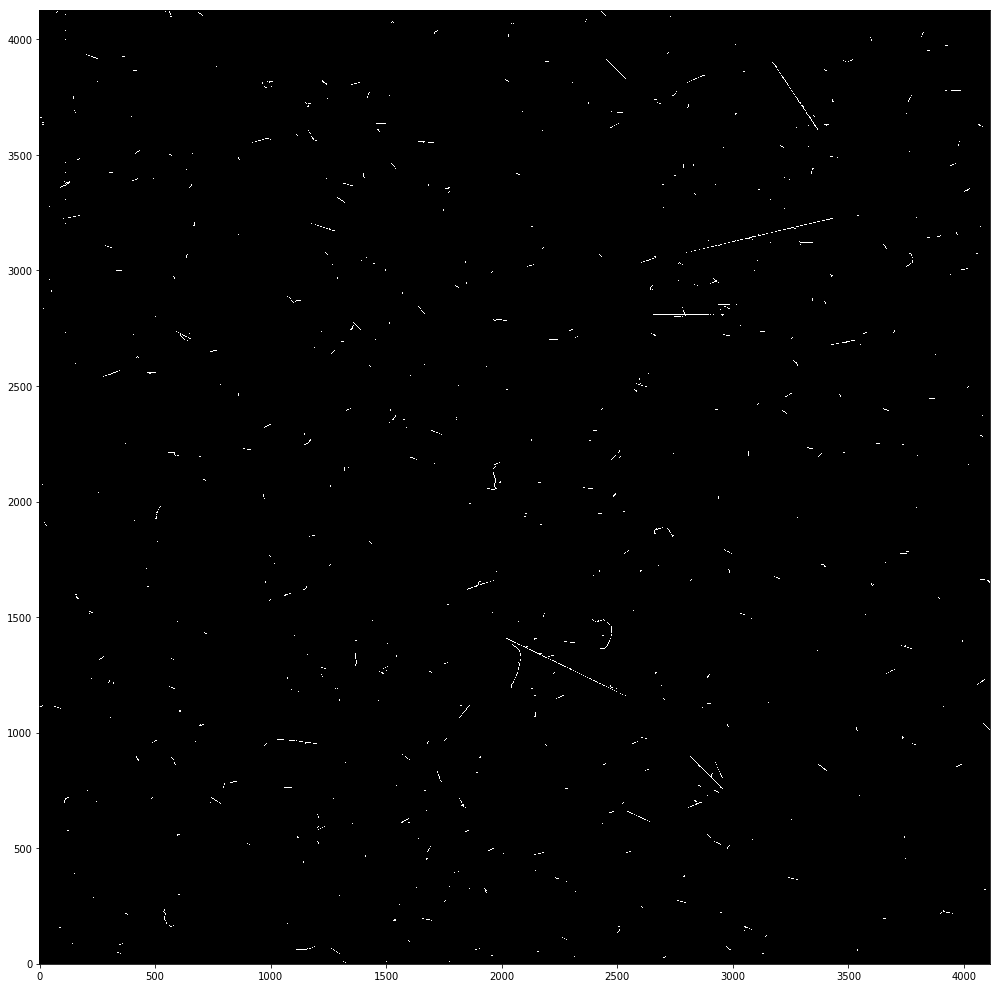

In [20]:
mask = mask > 0

fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
ax.imshow(mask, origin="lower", cmap="gray")

In [21]:
# Normalization for the image to display nicer (ish)
zscale = ZScaleInterval()
norm = ImageNormalize(new_img, zscale)

fig, ax = plt.subplots(1, 3, figsize=(14, 28), tight_layout=True)
ax[0].imshow(img[0:2000, 0:2000], cmap='gray', origin="lower", interpolation="none", norm=norm)
ax[0].set_title("Real Image")

ax[1].imshow(med_img[0:2000, 0:2000], cmap='gray', origin="lower", interpolation="none", norm=norm)
ax[1].set_title("Median (Clean) Image")

ax[2].imshow(new_img[0:2000, 0:2000], cmap='gray', origin="lower", interpolation="none", norm=norm)
ax[2].set_title("Simulated Image")

# fig.suptitle("Example Data")
plt.savefig("example_data.png", bbox_inches="tight", dpi=256)

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [27]:
def generate_training_image(input_img, input_ivar, num_cosmics):
    selected = np.random.rand(num_cosmics) * len(cosmics)
    selected = selected.astype("int")

    y_coords = np.random.rand(num_cosmics) * med_img.shape[0]
    y_coords = y_coords.astype("int")
    x_coords = np.random.rand(num_cosmics) * med_img.shape[1]
    x_coords = x_coords.astype("int")

    new_img = np.copy(input_img)
    new_ivar = np.copy(input_ivar)

    mask = np.zeros_like(new_img)

    for i, cosmic_index in enumerate(selected):
        cosmic = cosmics[cosmic_index].astype(new_img.dtype)

        x_start = x_coords[i]
        y_start = y_coords[i]
        x_end = x_coords[i] + cosmic.shape[1]
        y_end = y_coords[i] + cosmic.shape[0]
        if y_end > new_img.shape[0]: 
            y_start = new_img.shape[0] - cosmic.shape[0] - 1
            y_end = -1
        if x_end > new_img.shape[1]:
            x_start = new_img.shape[1] - cosmic.shape[1] - 1
            x_end = -1


        new_img[y_start:y_end, x_start:x_end] += cosmic# * 500
        mask[y_start:y_end, x_start:x_end] += cosmic_masks[cosmic_index]
        
        # Initializing to 0 because we want to maintain 0 ivars as 0
        # threse three lins initialize temp_ivar as 0s then inverts the values.
        # Anywhere where the value is 0, it is maintaned as 0 due to the where 
        # in the true divide.
        vals = new_ivar[y_start:y_end, x_start:x_end]
        temp_ivar = np.zeros_like(vals, dtype="float")
        np.true_divide(1, vals, out=temp_ivar, where=(vals!=0))
        
        # Now we do the same for the cosmic itself
        vals = cosmic_ivar[cosmic_index].astype(new_ivar.dtype)
        c_ivar = np.zeros_like(vals)
        np.true_divide(1, vals, out=c_ivar, where=(vals!= 0))
        
        # Once more to return to ivar
        temp_ivar = temp_ivar + c_ivar
        final_ivar = np.zeros_like(temp_ivar)
        np.true_divide(1, temp_ivar, out=final_ivar, where=(temp_ivar!= 0))
        
        new_ivar[y_start:y_end, x_start:x_end] = final_ivar
        
    return (new_img, new_ivar, mask)

In [28]:
num_training = 13

medians = os.listdir("medians")
# Linux can be stupid too.
if ".ipynb_checkpoints" in medians:
    medians.remove(".ipynb_checkpoints")

np.random.seed(0)
indices = np.random.rand(num_training) * len(medians)
indices = indices.astype("int16")

# Ten cameras and I want a good mix I guess lol
cams = np.random.rand(num_training) * 10
cams = cams.astype("int16")

for i in range(0, num_training):
    with fits.open(f"medians/{medians[indices[i]]}") as med_hdus:
        # Strips out all the cam names, sets them to empty string if its the ivars or not R band.
        # Then we kill the empty strings.
        cam_names = [med_hdus[i].name if (len(med_hdus[i].name) < 3 and med_hdus[i].name[0] == "R") else "" for i in range(0, len(med_hdus))]
        cam_names = [i for i in cam_names if i]

        # Super sloppy way to generate a single random number using the numpy random.
        # Why? Because I set the numpy random seed and I want this to be the same everytime lol.
        cam_ind = (np.random.rand(1) * len(cam_names)).astype("int16")[0]
        
        med_img = med_hdus[cam_names[cam_ind]].data
        ivar_img = med_hdus[f"{cam_names[cam_ind]}IVAR"].data

        num_cosmics = int(a * int(hdus["R1"].header["EXPTIME"]))

        new_img, new_ivar, mask = generate_training_image(med_img, ivar_img, num_cosmics)
        print(np.median(new_img[mask > 0]), np.mean(new_img[mask > 0]))

        hd0 = fits.PrimaryHDU()
        hd1 = fits.ImageHDU(new_img, name="IMAGE")
        hd2 = fits.ImageHDU(mask * 255, name="MASK")
        hd3 = fits.ImageHDU(new_ivar, name="IVAR")
        hdul = fits.HDUList([hd0, hd1, hd2, hd3])
        hdul.writeto(f"data/{i}-{cam_names[cam_ind]}.fits.fz", overwrite=True)

        print(f"Saved {i}-{cam_names[cam_ind]}.fits.fz")
print("Done!")

213.0 430.736004484
Saved 0-R9.fits.fz
204.0203339 433.136983032
Saved 1-R0.fits.fz
200.89780245 403.638018175
Saved 2-R0.fits.fz
99.8920596 320.144057626
Saved 3-R7.fits.fz
80.1371225 314.029558175
Saved 4-R4.fits.fz
191.0378552 401.4161389
Saved 5-R0.fits.fz
206.4554936 422.602502671
Saved 6-R8.fits.fz
199.924333375 407.367917204
Saved 7-R4.fits.fz
165.99748015 393.964439976
Saved 8-R4.fits.fz
200.0 399.791683245
Saved 9-R0.fits.fz
198.0 398.65144516
Saved 10-R4.fits.fz
208.780691 500.822318892
Saved 11-R7.fits.fz
208.77113965 425.818458678
Saved 12-R5.fits.fz
Done!
